In [1]:
#codigo para cargar los datos en 2 df, uno para el game_info y otro para las reviews

import pandas as pd
import ast

def json_line_generator(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                data_object = ast.literal_eval(line)
                yield data_object


df_games = pd.DataFrame(json_line_generator("steam_games/steam_games.json"))
df_reviews = pd.DataFrame(json_line_generator("steam_reviews/steam_new.json"))
print("Número total de registros cargados en df_games:", len(df_games))

print("\nNúmero total de registros cargados en df_reviews:", len(df_reviews))

Número total de registros cargados en df_games: 32135

Número total de registros cargados en df_reviews: 7793069


In [3]:
#poner una columna de el nombre del juego en el df de reviews
df_games_info = df_games[['id', 'title']].rename(columns={'id': 'product_id', 'title': 'game_title'})
df_reviews = pd.merge(
    df_reviews,                       
    df_games_info,                    
    on='product_id',                  
    how='left'                        
)

In [4]:
df_reviews.head(5)

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id,game_title
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN,Psi Project
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN,Gunspell - Steam Edition
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN,Gunspell - Steam Edition
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN,Batman: Arkham Asylum Game of the Year Edition
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075,Batman: Arkham Asylum Game of the Year Edition


In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocess_text(text):
    if text is None or text == "":
        return []
    
    #minuscula + ruido
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) #URLs
    text = re.sub(r'<.*?>', '', text)       #etiquetas HTML
    text = re.sub(r'[^a-záéíóúüñ\s]', '', text) #caracteres no alfabéticos 

    #tokenizacion
    tokens = word_tokenize(text)
    
    #stopwords 
    spanish_stopwords = set(stopwords.words('spanish'))
    english_stopwords = set(stopwords.words('english'))
    all_stopwords = spanish_stopwords.union(english_stopwords)

    filtered_tokens = [word for word in tokens if word not in all_stopwords and len(word) > 1]
    
    return filtered_tokens

df_reviews['processed_tokens'] = df_reviews['text'].apply(preprocess_text)
df_reviews['processed_text'] = df_reviews['processed_tokens'].apply(lambda x: ' '.join(x))

Número total de reviews procesadas: 7671591
Loss after epoch 0: 63223392.0
Loss after epoch 1: 12383648.0
Loss after epoch 2: 9235232.0
Loss after epoch 3: 9075672.0
Loss after epoch 4: 8634048.0
Loss after epoch 5: 8205912.0
Loss after epoch 6: 7578088.0
Loss after epoch 7: 7010768.0
Loss after epoch 8: 6116464.0
Loss after epoch 9: 2754504.0

Vocabulario construido con 257921 palabras únicas


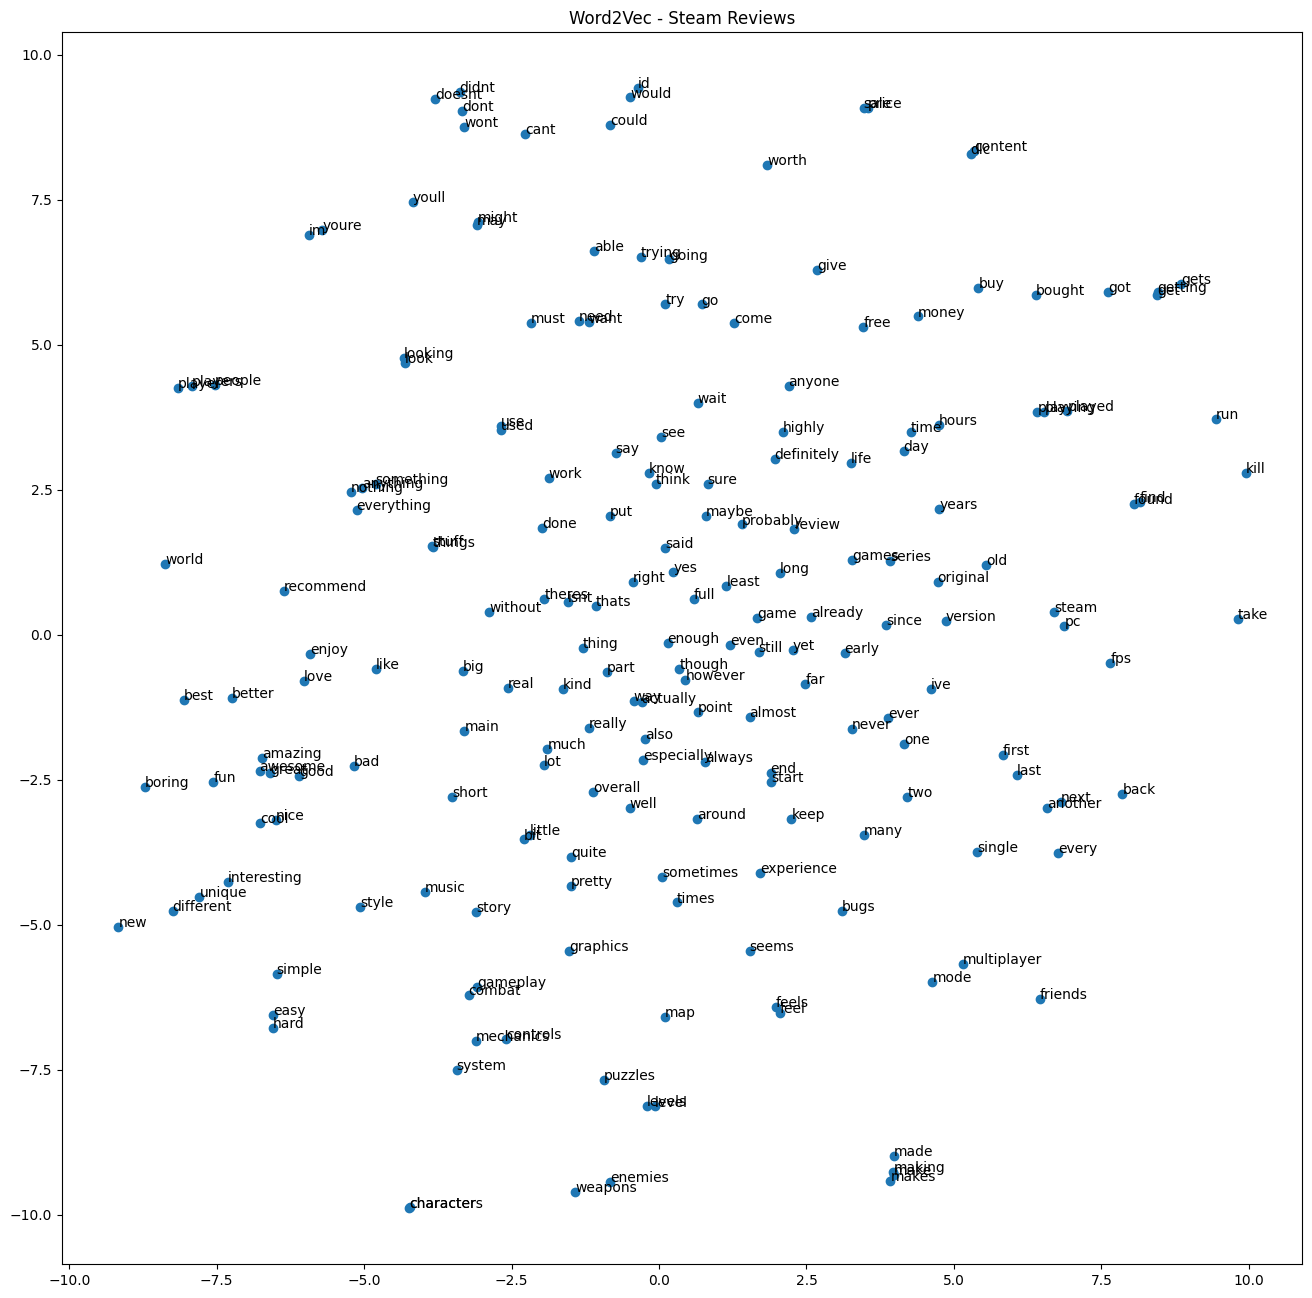


Modelo guardado como 'steam_reviews_w2v_model'

--- Ejemplos de palabras similares ---

Palabras similares a 'game':
  title: 0.5613
  games: 0.5605
  gameit: 0.5506
  however: 0.5180
  gamebut: 0.5105

Palabras similares a 'good':
  decent: 0.8007
  great: 0.7974
  nice: 0.7078
  awesome: 0.6730
  solid: 0.6398

Palabras similares a 'bad':
  terrible: 0.7700
  horrible: 0.7208
  awful: 0.6737
  good: 0.6321
  poor: 0.6271

Palabras similares a 'fun':
  enjoyable: 0.7149
  entertaining: 0.6907
  addicting: 0.6393
  addictive: 0.5908
  funthe: 0.5751

Palabras similares a 'play':
  paly: 0.6919
  playing: 0.6837
  toaround: 0.5248
  playbut: 0.5183
  played: 0.4987


In [5]:
#Crear word2vec con los tokens procesados

import gensim.models
from gensim.models.callbacks import CallbackAny2Vec
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

class EpochLogger(CallbackAny2Vec):
    '''Callback to log information about training'''

    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss - self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

sentences = [tokens for tokens in df_reviews['processed_tokens'].values if len(tokens) > 0]

print(f"Número total de reviews procesadas: {len(sentences)}")

#crear Word2Vec
epoch_logger = EpochLogger()

model = gensim.models.Word2Vec(
    sentences=sentences, 
    vector_size=200, 
    window=5, 
    min_count=5,  
    compute_loss=True, 
    callbacks=[epoch_logger], 
    negative=5, 
    epochs=10,  
    workers=4  
    
)

print(f"\nVocabulario construido con {len(model.wv)} palabras únicas")

# Visualización con TSNE
# Selecciona las primeras 200 palabras más frecuentes
words = list(model.wv.index_to_key)[:200]
vectors = [model.wv[word] for word in words]

# Aplica TSNE
tsne = TSNE(n_components=2, random_state=0, perplexity=30)
tsne_vectors = tsne.fit_transform(np.array(vectors))

plt.figure(figsize=(16, 16))
plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, (tsne_vectors[i, 0], tsne_vectors[i, 1]))

plt.title('Word2Vec - Steam Reviews')
plt.show()

#guardar modelo
model.save("steam_reviews_w2v_model")
print("\nModelo guardado como 'steam_reviews_w2v_model'")

#ejemplos
print("\nEjemplos de palabras similares")
test_words = ['game', 'good', 'bad', 'fun', 'play']
for word in test_words:
    if word in model.wv:
        print(f"\nPalabras similares a '{word}':")
        similar = model.wv.most_similar(word, topn=5)
        for similar_word, score in similar:
            print(f"  {similar_word}: {score:.4f}")

In [6]:
#obtener vector de cada review
def get_document_vector(tokens, model):
    
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])
    
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Aplicar a todas las reviews
print("Creando vectores de documento para cada review...")
df_reviews['doc_vector'] = df_reviews['processed_tokens'].apply(
    lambda tokens: get_document_vector(tokens, model)
)
print(f"Vectores creados con dimensión: {model.vector_size}")

Creando vectores de documento para cada review...
Vectores creados con dimensión: 200


In [1]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_reviews(review_index, df_reviews, top_n=5):
    """
    Encuentra las reviews más similares a una dada
    """
    target_vector = df_reviews.iloc[review_index]['doc_vector'].reshape(1, -1)
    
    # Calcular similitud con todas las reviews
    all_vectors = np.stack(df_reviews['doc_vector'].values)
    similarities = cosine_similarity(target_vector, all_vectors)[0]
    
    # Obtener índices de las más similares (excluyendo la misma review)
    similar_indices = similarities.argsort()[-top_n-1:-1][::-1]
    
    print(f"\n{'='*80}")
    print(f"REVIEW ORIGINAL (índice {review_index}):")
    print(f"{'='*80}")
    print(f"Juego: {df_reviews.iloc[review_index]['game_title']}")
    print(f"Usuario: {df_reviews.iloc[review_index]['username']}")
    print(f"Texto: {df_reviews.iloc[review_index]['text'][:200]}...")
    
    print(f"\n{'='*80}")
    print(f"TOP {top_n} REVIEWS SIMILARES:")
    print(f"{'='*80}")
    
    for i, idx in enumerate(similar_indices, 1):
        print(f"\n{i}. Similitud: {similarities[idx]:.4f}")
        print(f"   Juego: {df_reviews.iloc[idx]['game_title']}")
        print(f"   Usuario: {df_reviews.iloc[idx]['username']}")
        print(f"   Texto: {df_reviews.iloc[idx]['text'][:150]}...")

# Ejemplo de uso
find_similar_reviews(0, df_reviews, top_n=5)

NameError: name 'df_reviews' is not defined

In [ ]:
def semantic_search(query, df_reviews, model, top_n=10):
    """
    Busca reviews similares a una consulta de texto
    """
    # Preprocesar la consulta
    query_tokens = preprocess_text(query)
    query_vector = get_document_vector(query_tokens, model).reshape(1, -1)
    
    # Calcular similitud
    all_vectors = np.stack(df_reviews['doc_vector'].values)
    similarities = cosine_similarity(query_vector, all_vectors)[0]
    
    # Top resultados
    top_indices = similarities.argsort()[-top_n:][::-1]
    
    print(f"\n{'='*80}")
    print(f"BÚSQUEDA: '{query}'")
    print(f"{'='*80}")
    
    for i, idx in enumerate(top_indices, 1):
        print(f"\n{i}. Similitud: {similarities[idx]:.4f}")
        print(f"   Juego: {df_reviews.iloc[idx]['game_title']}")
        print(f"   Usuario: {df_reviews.iloc[idx]['username']}")
        print(f"   Texto: {df_reviews.iloc[idx]['text'][:200]}...")

# Ejemplos de búsqueda
semantic_search("amazing graphics and gameplay", df_reviews, model, top_n=5)
semantic_search("terrible bugs and crashes", df_reviews, model, top_n=5)
semantic_search("great story multiplayer fun", df_reviews, model, top_n=5)

In [ ]:
from sklearn.cluster import KMeans
from collections import Counter

def cluster_reviews(df_reviews, n_clusters=5):
    """
    Agrupa reviews en clusters usando K-means
    """
    print(f"\nRealizando clustering con {n_clusters} clusters...")
    
    # Preparar datos
    vectors = np.stack(df_reviews['doc_vector'].values)
    
    # K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df_reviews['cluster'] = kmeans.fit_predict(vectors)
    
    print(f"\nDistribución de reviews por cluster:")
    cluster_counts = Counter(df_reviews['cluster'])
    for cluster_id, count in sorted(cluster_counts.items()):
        print(f"  Cluster {cluster_id}: {count} reviews")
    
    return kmeans

# Ejecutar clustering
kmeans_model = cluster_reviews(df_reviews, n_clusters=5)

# Ver ejemplos de cada cluster
def show_cluster_examples(df_reviews, cluster_id, n_examples=3):
    """
    Muestra ejemplos de reviews de un cluster específico
    """
    cluster_reviews = df_reviews[df_reviews['cluster'] == cluster_id]
    
    print(f"\n{'='*80}")
    print(f"EJEMPLOS DEL CLUSTER {cluster_id} ({len(cluster_reviews)} reviews)")
    print(f"{'='*80}")
    
    for i, (idx, row) in enumerate(cluster_reviews.head(n_examples).iterrows(), 1):
        print(f"\n{i}. Juego: {row['game_title']}")
        print(f"   Usuario: {row['username']}")
        print(f"   Texto: {row['text'][:200]}...")

# Ver ejemplos de cada cluster
for cluster_id in range(5):
    show_cluster_examples(df_reviews, cluster_id, n_examples=3)

In [ ]:
def analyze_cluster_words(df_reviews, model, top_n=10):
    """
    Encuentra las palabras más representativas de cada cluster
    """
    print(f"\n{'='*80}")
    print("PALABRAS MÁS CARACTERÍSTICAS POR CLUSTER")
    print(f"{'='*80}")
    
    for cluster_id in sorted(df_reviews['cluster'].unique()):
        cluster_reviews = df_reviews[df_reviews['cluster'] == cluster_id]
        
        # Contar palabras en el cluster
        word_freq = {}
        for tokens in cluster_reviews['processed_tokens']:
            for word in tokens:
                if word in model.wv:
                    word_freq[word] = word_freq.get(word, 0) + 1
        
        # Top palabras
        top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:top_n]
        
        print(f"\nCluster {cluster_id}:")
        print(f"  Palabras: {', '.join([f'{word}({freq})' for word, freq in top_words])}")

analyze_cluster_words(df_reviews, model, top_n=15)

In [ ]:
import pickle

# Guardar modelo de Word2Vec (ya lo haces)
model.save("steam_reviews_w2v_model")

# Guardar DataFrame con vectores y clusters
df_reviews.to_pickle("df_reviews_with_embeddings.pkl")
print("\n✅ DataFrame con vectores y clusters guardado en 'df_reviews_with_embeddings.pkl'")

# Guardar solo los vectores en formato numpy para uso posterior
vectors_array = np.stack(df_reviews['doc_vector'].values)
np.save("review_vectors.npy", vectors_array)
print("✅ Vectores guardados en 'review_vectors.npy'")

# Guardar modelo de clustering
with open("kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans_model, f)
print("✅ Modelo de clustering guardado en 'kmeans_model.pkl'")

In [ ]:
def load_embeddings_model():
    """
    Carga el modelo y los datos guardados
    """
    # Cargar modelo Word2Vec
    model = gensim.models.Word2Vec.load("steam_reviews_w2v_model")
    
    # Cargar DataFrame
    df_reviews = pd.read_pickle("df_reviews_with_embeddings.pkl")
    
    # Cargar vectores
    vectors = np.load("review_vectors.npy")
    
    # Cargar modelo clustering
    with open("kmeans_model.pkl", "rb") as f:
        kmeans_model = pickle.load(f)
    
    print("✅ Modelos y datos cargados correctamente")
    return model, df_reviews, vectors, kmeans_model

# Para usar más tarde:
# model, df_reviews, vectors, kmeans_model = load_embeddings_model()

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_clusters(df_reviews, n_samples=1000):
    """
    Visualiza los clusters usando t-SNE (con muestra aleatoria)
    """
    print(f"\nVisualizando clusters (muestra de {n_samples} reviews)...")
    
    # Tomar muestra aleatoria
    sample_df = df_reviews.sample(n=min(n_samples, len(df_reviews)), random_state=42)
    vectors_sample = np.stack(sample_df['doc_vector'].values)
    
    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_vectors = tsne.fit_transform(vectors_sample)
    
    # Plot
    plt.figure(figsize=(14, 10))
    scatter = plt.scatter(
        tsne_vectors[:, 0], 
        tsne_vectors[:, 1],
        c=sample_df['cluster'].values,
        cmap='tab10',
        alpha=0.6,
        s=50
    )
    plt.colorbar(scatter, label='Cluster')
    plt.title('Visualización de Clusters de Reviews (t-SNE)', fontsize=16)
    plt.xlabel('Dimensión 1')
    plt.ylabel('Dimensión 2')
    plt.tight_layout()
    plt.savefig('clusters_visualization.png', dpi=150)
    print("✅ Visualización guardada como 'clusters_visualization.png'")
    plt.show()

visualize_clusters(df_reviews, n_samples=2000)


print("\n" + "="*80)
print("✅ PROCESO DE EMBEDDINGS COMPLETADO")
print("="*80)
print("\nArchivos generados:")
print("  - steam_reviews_w2v_model: Modelo Word2Vec")
print("  - df_reviews_with_embeddings.pkl: DataFrame con vectores y clusters")
print("  - review_vectors.npy: Vectores en formato numpy")
print("  - kmeans_model.pkl: Modelo de clustering")
print("  - clusters_visualization.png: Visualización de clusters")